In [ ]:
#!pip3 install tensorflow==1.4.0

tensorflow 1.4.0 버젼에서 정상 동작이 되기 때문에
위의 Code를 1회 수행 해야 함. 

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
from time import time
import cv2

%matplotlib inline
from matplotlib import pyplot as plt

print(tf.__version__)
print(cv2.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Super Resolution Model 선언**

In [ ]:
with tf.variable_scope("shared_model"):
	input_tensor = tf.placeholder(tf.float32, shape=(1,None,None, 1))
	conv_00_w = tf.get_variable("conv_00_w", [5,1,1,8], initializer=tf.random_normal_initializer(stddev=np.sqrt(2.0/9)))
	conv_00_b = tf.get_variable("conv_00_b", [8], initializer=tf.constant_initializer(0))
	tensor = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input_tensor, conv_00_w, strides=[1,1,1,1], padding='SAME'), conv_00_b))
	for i in range(4):
		conv_w = tf.get_variable("conv_%02d_w" % (2*i+1), [1,5,8,8], initializer=tf.random_normal_initializer(stddev=np.sqrt(2.0/9/64)))
		conv_b = tf.get_variable("conv_%02d_b" % (2*i+1), [8], initializer=tf.constant_initializer(0))
		tensor = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(tensor, conv_w, strides=[1,1,1,1], padding='SAME'), conv_b))
		conv_w = tf.get_variable("conv_%02d_w" % (2*i+2), [5,1,8,8], initializer=tf.random_normal_initializer(stddev=np.sqrt(2.0/9/64)))
		conv_b = tf.get_variable("conv_%02d_b" % (2*i+2), [8], initializer=tf.constant_initializer(0))
		tensor = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(tensor, conv_w, strides=[1,1,1,1], padding='SAME'), conv_b))

	conv_w = tf.get_variable("conv_09_w", [1,5,8,8], initializer=tf.random_normal_initializer(stddev=np.sqrt(2.0/9/64)))
	conv_b = tf.get_variable("conv_09_b", [8], initializer=tf.constant_initializer(0))
	tensor = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(tensor, conv_w, strides=[1,1,1,1], padding='SAME'), conv_b))

	conv_w = tf.get_variable("conv_10_w", [5,1,8,4], initializer=tf.random_normal_initializer(stddev=np.sqrt(2.0/9/64)))
	conv_b = tf.get_variable("conv_10_b", [4], initializer=tf.constant_initializer(0))
	tensor = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(tensor, conv_w, strides=[1,1,1,1], padding='SAME'), conv_b))

	conv_w = tf.get_variable("conv_20_w", [1,5,4,4], initializer=tf.random_normal_initializer(stddev=np.sqrt(2.0/9/64)))
	conv_b = tf.get_variable("conv_20_b", [4], initializer=tf.constant_initializer(0))
	tensor = tf.nn.bias_add(tf.nn.conv2d(tensor, conv_w, strides=[1,1,1,1], padding='SAME'), conv_b)
	tensor = tf.add(tensor, input_tensor)





In [ ]:
saver=tf.train.Saver()

sess=tf.Session()
saver.restore(sess, "VDSR_adam_epoch_061.ckpt-139004")

INFO:tensorflow:Restoring parameters from VDSR_adam_epoch_061.ckpt-139004


In [ ]:
def shuffle_image(input_image, us_factor):
	IMG_SIZE = input_image.shape
	print(IMG_SIZE)  # IMG_SIZE = (512,512,4)
 	# us_factor = 2
	shuffled = np.zeros((int(IMG_SIZE[0] * us_factor),int(IMG_SIZE[1] * us_factor))) 

	for y in range( int(IMG_SIZE[0])):
		for x in range(int(IMG_SIZE[1])):
			shuffled[2 * y, 2 * x] = input_image[y, x, 0]
			shuffled[2 * y, 2 * x + 1] = input_image[y, x, 1]
			shuffled[2 * y + 1, 2 * x] = input_image[y, x, 2]
			shuffled[2 * y + 1, 2 * x + 1] = input_image[y, x, 3]                
	print(shuffled.shape)
	return shuffled

(1, 512, 512, 1)
PROCESSING TIME FOR RESOLUTION 512x512 IS 0.381275sec
befor_img_shape=  (512, 512)


True

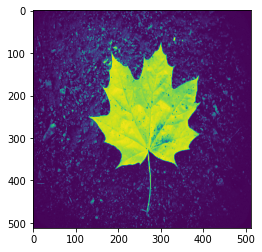

In [ ]:
img = cv2.imread("hi.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img)
ret = cv2.waitKey(0)
#print("hi.jpg Image",img.shape)
res = (512, 512)
img = cv2.resize(img,(512,512))
#print("Resized",img.shape)
img_shape = img.shape
#plt.imshow(img)
#time.sleep(3)
#plt.close()
#print("img_shpae = " , img_shape)
cv2.imwrite('test_sqr2.png',img)
img = cv2.imread('test_sqr2.png', cv2.IMREAD_GRAYSCALE)


img=img.reshape( (1,) + img_shape + (1,) )
print(img.shape)

#normalize[0,1]
# will be done in XNNC (mean=0, std=25500)
img = img/255.   # int --> float
#print(img.shape , img[0][0])

# TIME STAMP BEFORE
t1 = time()
out = sess.run([tensor],feed_dict={input_tensor:img})
print("PROCESSING TIME FOR RESOLUTION %dx%d IS %fsec"%(res[0], res[1],float(time()-t1)))

# CALC DIFFERENCE
np.save('residual_sqr.npy', out[0])

print("befor_img_shape= ",img.reshape(img_shape).shape)
plt.imshow(img.reshape(img_shape))
cv2.imwrite('befor_image.bmp',img.reshape(img_shape))



> 들여쓴 블록



(512, 512, 4)
(1024, 1024)
(512, 512, 4)
(1024, 1024)


True

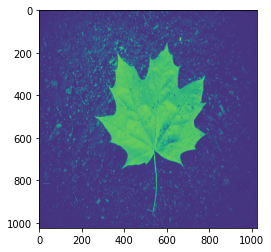

In [ ]:
plt.imshow(shuffle_image(out[0][0],2))

cv2.imwrite('shuffle_image.png',shuffle_image(out[0][0],2))